# Imports

In [41]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Load and Examine CSV Data

In [42]:
rock_hiphop_data = pd.read_csv('../input/rockvshiphop/fma-rock-vs-hiphop.csv', index_col='track_id')
rock_hiphop_data

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]","[58, 12, 45]",NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]","[58, 12, 45]",NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],"[25, 12]",NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],"[25, 12]",NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],"[26, 12]",NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155063,320000,0,NaN,2017-03-24 19:40:43,NaN,283,3,Hip-Hop,"[21, 811]","[811, 21]",NaN,1283,NaN,Attribution,1050,NaN,4,NaN,"['old school beats', '2017 free instrumentals'...",Been On
155064,320000,0,NaN,2017-03-24 19:40:44,NaN,250,2,Hip-Hop,"[21, 811]","[811, 21]",NaN,1077,NaN,Attribution,858,NaN,2,NaN,"['old school beats', '2017 free instrumentals'...",Send Me
155065,320000,0,NaN,2017-03-24 19:40:45,NaN,219,3,Hip-Hop,"[21, 811]","[811, 21]",NaN,1340,NaN,Attribution,1142,NaN,1,NaN,"['old school beats', '2017 free instrumentals'...",The Question


## Preparing CSV Data

In [43]:
# columns with null data
rock_hiphop_data.columns[rock_hiphop_data.isna().any()].tolist()

['composer',
 'date_recorded',
 'information',
 'language_code',
 'license',
 'lyricist',
 'publisher']

In [44]:
# dropping 'composer', 'information', 'lyricist', 'publisher' columns (with null values)
# + dropping 'tags', and 'title'
rock_hiphop_data.drop(['composer', 'information', 'lyricist', 'publisher', 'tags', 'title'], axis='columns', inplace=True)

In [45]:
# filling 'date_recorded' with the same value as the 'date_created'
rock_hiphop_data['date_recorded'].fillna(rock_hiphop_data.date_created, inplace=True)
rock_hiphop_data

,bit_rate,comments,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,interest,language_code,license,listens,number
track_id,,,,,,,,,,,,,,
135,256000,1,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]","[58, 12, 45]",2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,0
136,256000,1,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]","[58, 12, 45]",1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,0
151,192000,0,2008-11-26 01:44:55,2008-11-26 01:44:55,192,0,Rock,[25],"[25, 12]",701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,4
152,192000,0,2008-11-26 01:44:58,2008-11-26 01:44:58,193,0,Rock,[25],"[25, 12]",637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,11
153,256000,0,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],"[26, 12]",354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155063,320000,0,2017-03-24 19:40:43,2017-03-24 19:40:43,283,3,Hip-Hop,"[21, 811]","[811, 21]",1283,NaN,Attribution,1050,4
155064,320000,0,2017-03-24 19:40:44,2017-03-24 19:40:44,250,2,Hip-Hop,"[21, 811]","[811, 21]",1077,NaN,Attribution,858,2
155065,320000,0,2017-03-24 19:40:45,2017-03-24 19:40:45,219,3,Hip-Hop,"[21, 811]","[811, 21]",1340,NaN,Attribution,1142,1


In [46]:
#creating 'year_created', 'year_recorded', 'recording_period' columns
rock_hiphop_data['date_created'] = pd.to_datetime(rock_hiphop_data['date_created'], format="%Y %m %d %H")
rock_hiphop_data['year_created'] = rock_hiphop_data.date_created.dt.year

rock_hiphop_data['date_recorded'] = pd.to_datetime(rock_hiphop_data['date_recorded'], format="%Y %m %d %H")
rock_hiphop_data['year_recorded'] = rock_hiphop_data.date_recorded.dt.year

rock_hiphop_data['recording_period'] = (rock_hiphop_data.date_created - rock_hiphop_data.date_recorded).dt.days

In [47]:
rock_hiphop_data.head(10)

,bit_rate,comments,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,interest,language_code,license,listens,number,year_created,year_recorded,recording_period
track_id,,,,,,,,,,,,,,,,,
135,256000,1,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]","[58, 12, 45]",2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,0,2008,2008,0
136,256000,1,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]","[58, 12, 45]",1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,0,2008,2008,0
151,192000,0,2008-11-26 01:44:55,2008-11-26 01:44:55,192,0,Rock,[25],"[25, 12]",701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,4,2008,2008,0
152,192000,0,2008-11-26 01:44:58,2008-11-26 01:44:58,193,0,Rock,[25],"[25, 12]",637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,11,2008,2008,0
153,256000,0,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],"[26, 12]",354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,2,2008,2008,0
154,256000,0,2008-11-26 01:45:04,2008-11-26 00:00:00,319,1,Rock,[26],"[26, 12]",242,en,Attribution-NonCommercial-NoDerivatives (aka M...,205,4,2008,2008,0
155,192000,0,2008-11-26 01:45:10,2008-11-26 00:00:00,756,1,Rock,[26],"[26, 12]",268,en,Attribution-NonCommercial-NoDerivatives (aka M...,197,0,2008,2008,0
169,192000,0,2008-11-26 01:46:02,2006-01-01 00:00:00,144,1,Rock,[25],"[25, 12]",815,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,270,1,2008,2006,1060
170,192000,0,2008-11-26 01:46:05,2006-10-07 00:00:00,181,0,Rock,[25],"[25, 12]",468,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,122,2,2008,2006,781


In [48]:
# dropping 'date_created', 'date_recorded'
rock_hiphop_data.drop(['date_created', 'date_recorded'], axis='columns', inplace=True)

In [49]:
# filling 'language_code', and 'license' backward then forward
rock_hiphop_data['language_code'] = rock_hiphop_data.language_code.bfill().ffill()
rock_hiphop_data['license'] = rock_hiphop_data.license.bfill().ffill()

In [50]:
# splitting genres_all
import re
# get numbers from unique strings
list_genres_all = [re.findall('\d+', l) for l in rock_hiphop_data.genres_all.unique()]
# convert them to int, flatten list of lists, set of unique integers
flatten_genres_all = np.unique([int(item) for sublist in list_genres_all for item in sublist])
flatten_genres_all

array([ 12,  21,  25,  26,  27,  31,  36,  45,  53,  58,  64,  66,  70,
        71,  83,  85,  88,  89,  90,  98, 100, 101, 109, 111, 113, 167,
       314, 359, 361, 404, 439, 440, 539, 542, 580, 811])

In [51]:
# creating columns for different 36 genres
for i in range(len(flatten_genres_all)):
    rock_hiphop_data[f"genres_{flatten_genres_all[i]}"] = rock_hiphop_data.genres_all.map(lambda a: 1 if (str(flatten_genres_all[i]) in re.findall('\d+', a)) else 0)

In [52]:
rock_hiphop_data.genres_811.tail(30)

track_id
152545    0
153333    0
153334    0
153335    0
153336    0
153337    0
154292    1
154293    1
154294    1
154295    1
154296    1
154297    1
154298    1
154299    1
154300    1
154301    1
154302    1
154303    1
154304    1
154305    1
154306    1
154307    1
154308    1
154309    1
154919    1
155063    1
155064    1
155065    1
155066    1
155247    1
Name: genres_811, dtype: int64

In [53]:
# dropping 'genres', 'genres_all'
rock_hiphop_data.drop(['genres', 'genres_all'], axis='columns', inplace=True)

# Load and Examine JSON Data

In [54]:
f = open('../input/rockvshiphop/echonest-metrics.json',) 
  
# returns JSON object as  
# a dictionary 
metrics_data = json.load(f) 
  
f.close() 

metrics_df = pd.DataFrame.from_dict(metrics_data).set_index('track_id')
metrics_df

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072
...,...,...,...,...,...,...,...,...
124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461
124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845
124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667


## Preparing JSON Data

In [55]:
# columns with null data
metrics_df.columns[metrics_df.isna().any()].tolist()

[]

# Joining All Data

In [56]:
# joining data with 'track_id', rock_hiphop_data on the left, and metrics_df on the right
all_data = rock_hiphop_data.join(metrics_df)
all_data

,bit_rate,comments,duration,favorites,genre_top,interest,language_code,license,listens,number,...,genres_580,genres_811,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,,,,,,,,,,,,,,
135,256000,1,837,0,Rock,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,256000,1,509,0,Rock,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,192000,0,192,0,Rock,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,4,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,192000,0,193,0,Rock,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,11,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,256000,0,405,5,Rock,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,2,...,0,0,0.988306,0.255661,0.979774,0.973006,0.121342,0.05174,90.241,0.034018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155063,320000,0,283,3,Hip-Hop,1283,en,Attribution,1050,4,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155064,320000,0,250,2,Hip-Hop,1077,en,Attribution,858,2,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155065,320000,0,219,3,Hip-Hop,1340,en,Attribution,1142,1,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preparing All Data

In [57]:
# columns with null data
all_data.columns[all_data.isna().any()].tolist()

['acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'speechiness',
 'tempo',
 'valence']

In [58]:
all_data.bfill(inplace=True)
all_data.ffill(inplace=True)

In [59]:
all_data.columns[all_data.isna().any()].tolist()

[]

After getting **100%** from the **Decision Tree Model** and **99%** from the **Logistic Regression Model** (after scaling and applying PCA), I decided to drop the most correlated columns: 'genres_12', and 'genres_21', to prevent overfitting with new test data!!

So, Now I have got 
* **98%** from **Decision Tree Model** on the splitted data (before scaling and applying PCA), 
* **47%** from **Decision Tree Model** on the cross validated data (after scaling and applying PCA),
* **83%** from **Logistic Regression Model** on the splitted data (before scaling and applying PCA),
* **94.6%** from **Logistic Regression Model** on the cross validated data (after scaling and applying PCA)

In [60]:
# dropping 'genres_12', 'genres_21'
all_data.drop(['genres_12', 'genres_21'], axis='columns', inplace=True)

### Encoding the Target Data

In [61]:
# Apply label encoder 
label_encoder = LabelEncoder()
all_data.genre_top = label_encoder.fit_transform(all_data.genre_top)

# Train Test Split to All Data

In [62]:
# Remove rows with missing target, separate target from predictors
X = all_data.dropna(axis=0, subset=['genre_top'])
y = all_data.genre_top
X.drop(['genre_top'], axis=1, inplace=True)
# Scaling Features
#X_scaled = X.loc[:, X.columns]
#X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

## Dealing with Categorical Columns

In [63]:
# Seeing if we can apply Label Encoding
# All categorical columns
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(X_train[col]) == set(X_valid[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be label encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be label encoded: []

Categorical columns that will be dropped from the dataset: ['license', 'language_code']


In [64]:
# How many columns are needed to one-hot encode 
num_cols_language_code = X_train['language_code'].nunique()
print(num_cols_language_code)

# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 15]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

13
Categorical columns that will be one-hot encoded: ['language_code']

Categorical columns that will be dropped from the dataset: ['license']


In [65]:
from sklearn.preprocessing import OneHotEncoder

# Use as many lines of code as you need!
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

## Trying Decision Tree and Logistic Regression before Scaling/Normalizing

Validation MAE for Decision Tree: 0.01861
[[ 700   34]
 [  32 2781]]


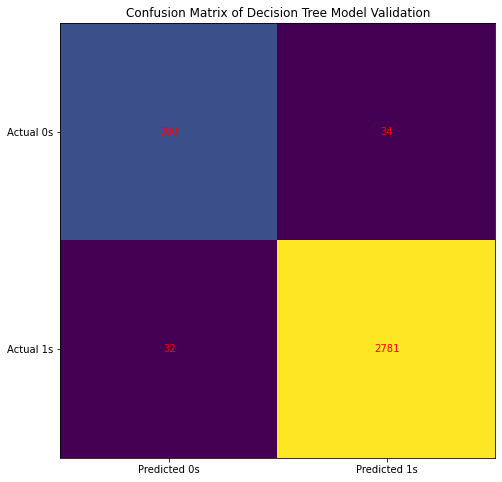

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       734
           1       0.99      0.99      0.99      2813

    accuracy                           0.98      3547
   macro avg       0.97      0.97      0.97      3547
weighted avg       0.98      0.98      0.98      3547



In [66]:
# DecisionTreeRegressor without Scaling
from sklearn.metrics import mean_absolute_error

dt_model = DecisionTreeRegressor(random_state=1)
dt_model.fit(X_train, y_train)

# Make validation predictions and calculate mean absolute error
val_predictions = dt_model.predict(X_valid)

val_mae = mean_absolute_error(val_predictions, y_valid)
print("Validation MAE for Decision Tree: {:,.5f}".format(val_mae))

cm = confusion_matrix(y_valid, val_predictions)
print(cm)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title("Confusion Matrix of Decision Tree Model Validation")
plt.show()

print(classification_report(y_valid, val_predictions))

Validation MAE for Logistic Regression: 0.17395
[[ 207  527]
 [  90 2723]]


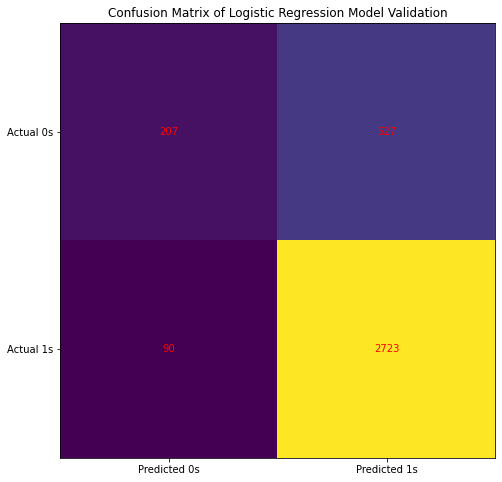

              precision    recall  f1-score   support

           0       0.70      0.28      0.40       734
           1       0.84      0.97      0.90      2813

    accuracy                           0.83      3547
   macro avg       0.77      0.63      0.65      3547
weighted avg       0.81      0.83      0.80      3547



In [67]:
#LogisticRegression without Scaling
lr_model = LogisticRegression(solver='liblinear', random_state=0)
lr_model.fit(X_train, y_train)
val_predictions = lr_model.predict(X_valid)

val_mae = mean_absolute_error(val_predictions, y_valid)
print("Validation MAE for Logistic Regression: {:,.5f}".format(val_mae))

cm = confusion_matrix(y_valid, val_predictions)
print(cm)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title("Confusion Matrix of Logistic Regression Model Validation")
plt.show()

print(classification_report(y_valid, val_predictions))

# Normalizing the Feature Data

In [68]:
# Scaling Features
X_scaled = X.loc[:, X.columns]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

# Get Mutual Information

### to select features to use in further analyses of PCA

In [69]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [70]:
mi_scores = make_mi_scores(X_scaled, y)
mi_scores

speechiness         0.387343
danceability        0.377513
tempo               0.369032
energy              0.355120
instrumentalness    0.353235
acousticness        0.343667
valence             0.337975
liveness            0.337598
genres_25           0.096460
bit_rate            0.065848
genres_100          0.036369
genres_539          0.034283
genres_66           0.026294
genres_85           0.026191
genres_811          0.024514
year_recorded       0.023252
recording_period    0.021780
favorites           0.021765
listens             0.019562
year_created        0.019457
number              0.018302
genres_53           0.018004
duration            0.017794
genres_27           0.017593
genres_45           0.014534
interest            0.013925
genres_64           0.011059
genres_89           0.011042
genres_58           0.009117
genres_113          0.009050
genres_90           0.008384
genres_404          0.008384
genres_36           0.008368
genres_542          0.007156
genres_359    

In [71]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

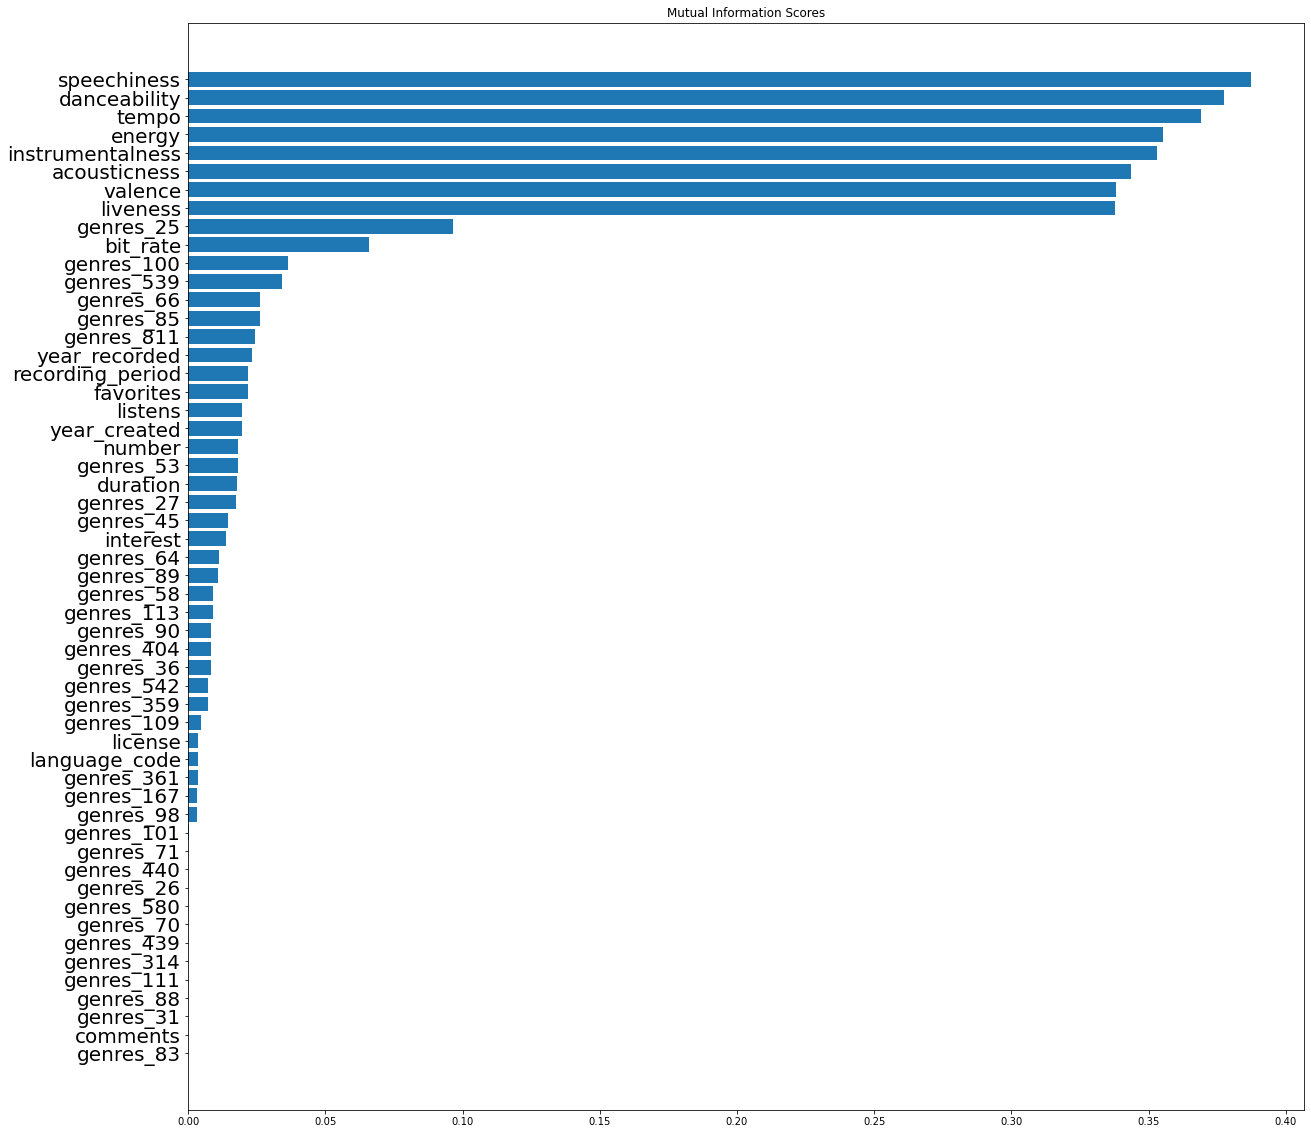

In [72]:
plt.figure(figsize=(20,20))
plt.yticks(fontsize=20)

plot_mi_scores(mi_scores)

# Applying PCA

In [75]:
features = [
  #  "genres_12",
  #  "genres_21",
    "speechiness",
    'danceability',
    'tempo',
    'energy',
    'instrumentalness'
]

print("Correlation with genre_top:\n")
print(X[features].corrwith(y))

Correlation with genre_top:

speechiness        -0.514095
danceability       -0.416232
tempo               0.336576
energy             -0.036353
instrumentalness    0.219477
dtype: float64


In [76]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [77]:
X = X.copy()
X = X.loc[:, features]

# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X)
print(loadings)

                       PC1       PC2       PC3       PC4       PC5
speechiness       0.553349 -0.074245  0.025201  0.829146 -0.013183
danceability      0.584198  0.306507  0.050899 -0.374308 -0.649668
tempo            -0.035732 -0.495536  0.849402 -0.049064 -0.171104
energy            0.000455 -0.765695 -0.524216 -0.058786 -0.368039
instrumentalness -0.592655  0.262100  0.022089  0.408101 -0.642673


## Applying Decision Tree and Logistic Regression on PCA columns

In [78]:
def score_dataset(X, y, model):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()), ('model', model)])
    
    scoring = ["accuracy","roc_auc","neg_log_loss","r2",
             "neg_mean_squared_error","neg_mean_absolute_error"] 
    
    score = cross_val_score(
        my_pipeline, X, y, cv=5, scoring="accuracy",
    )
    score = score.mean()#-1 * score.mean()
    #score = np.sqrt(score)
    return score

In [79]:
#X_scaled = X_scaled.join(X_pca)
score = score_dataset(X_scaled, y, DecisionTreeRegressor(random_state=0))
print(f"Decision Tree score: {score:.5f}")

Decision Tree score: 0.47003


In [80]:
score = score_dataset(X_scaled, y, LogisticRegression(solver='liblinear', random_state=0))
print(f"Logistic Regression score: {score:.5f}")

Logistic Regression score: 0.94677
